In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools
import json

### Introduction
In this notebook, you will find visualizations of processor reuse in workflows, in both Snakemake and Nextflow. 

* "levenshtein" between two processors p<1 and p2 is computed as follows, with  d = max(len(p1),len(p2)) : l(p1,p2) = (d-levenshtein(p1,p2))/d. It is a normalization that allows us to have a similarity measure from the edit distance.

To obtain groups of similar processors with levenshtein, we used a treshold of 0.85 on their similarity score to deem them similar. For each group, with p1 and p2 processors in this group, if p1 and p2 were in the group they eather had a similarity score higher than the treshold and if not, each have a similarity score higher than the treshold with a third processor p3 in the group.

In [22]:
def importing_json_files(file_wf):
    f_wf = open(file_wf) #informations for nf
    # returns JSON object as
    # a dictionary
    wf = json.load(f_wf)
    f_wf.close
    return wf

#importing the wf and auth dict (github info)
dict_nf = importing_json_files('../json/source_files/wf_new_crawl_nextflow.json')
auth_nf = importing_json_files('../json/source_files/author_clem_nf.json')

#import processes dictionnaries
with open('../json/source_files/nf_proc_tool_shell.json') as f:
    nf_proc = json.load(f)
    
#importing the wf and auth dict (github info)
dict_snk = importing_json_files('../json/source_files/wf_crawl_snakemake.json')
auth_snk = importing_json_files('../json/source_files/author_clem_snk.json')

#import processes dictionnaries
with open('../json/source_files/snk_proc_tool_shell.json') as f:
    snk_proc = json.load(f)

In [23]:
#importing the similarity groups df for nextflow and nf-core


#Nextflow

nf_json = importing_json_files("../json/source_files/results/sim_nf_lev.json")
df_nf_proc= pd.DataFrame(nf_json)
df_nf_lev_wf = pd.read_csv("../csv/sim_nf_lev_wf.csv")

#Nf-core

nf_non_nfc_json = importing_json_files("../json/source_files/results/sim_nf_lev_non_nfc.json")
df_nf_non_nfc_proc= pd.DataFrame(nf_non_nfc_json)
df_nf_lev_non_nfc_wf = pd.read_csv("../csv/sim_nf_lev_non_nfc_wf.csv")

nf_nfc_json = importing_json_files("../json/source_files/results/sim_nf_lev_nfc.json")
df_nf_nfc_proc= pd.DataFrame(nf_nfc_json)
df_nf_lev_nfc_wf = pd.read_csv("../csv/sim_nf_lev_nfc_wf.csv")

#Snakemake

snk_json = importing_json_files("../json/source_files/results/sim_snk_lev.json")
df_snk_proc= pd.DataFrame(snk_json)
df_snk_lev_wf = pd.read_csv("../csv/sim_snk_lev_wf.csv")


### Processors reuse in workflows

Let us look at the repartiiton of processors reuse in workflows. We look at how many workflows a processor is reused in. We will first compare the distribution of processor reuse in Snakemake and in Nextflow. Then, we will zoom in on Nf-core processors in non nextflow workflows.

### Nextflow and Snakemake

In [13]:
def make_df_tot(df_a,df_b,metric):
    
    df_a["prop_proc_nf"]=df_a["prop_proc"]
    df_b["prop_proc_snk"]=df_b["prop_proc"]
    df_tot = pd.merge(df_a[[metric,"prop_proc_nf"]], df_b[[metric,"prop_proc_snk"]],on=metric,how="outer") 
    
    df_tot = df_tot.fillna(0)
    df_tot=df_tot.sort_values(by=[metric], ascending=True)
    return df_tot

In [14]:
def disp_fig_props_wf(df,sys):
    
    #plt.rcParams.update({'font.size': 15})
    df_tot =df[df["nb_wf"]>1]
    df_tot['nb_wf'] = [int(el) for el in list(df_tot["nb_wf"]) ] 
    df_tot = df_tot.sort_values(by="nb_wf")
    fig = df_tot.plot(x="nb_wf",y=["prop_proc_nf","prop_proc_snk"], kind="bar", color = ['blue',"red"], label = ["Nextflow", "Snakemake"])
    fig.set_xticklabels( fig.get_xticklabels(), rotation=80, size=5)
    fig.set_xlabel("Number of workflows")
    fig.set_ylabel('% of processors')
    fig.legend(loc='best')
    fig.set_yscale('log')
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    
    fig.figure.savefig("../figures/hist_reuse_wf_nf_snk.pdf",bbox_inches = 'tight')
    return fig

In [15]:
df_tot = make_df_tot(df_nf_lev_wf,df_snk_lev_wf,"nb_wf")

/tmp/ipykernel_40397/2632616607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot['nb_wf'] = [int(el) for el in list(df_tot["nb_wf"]) ]


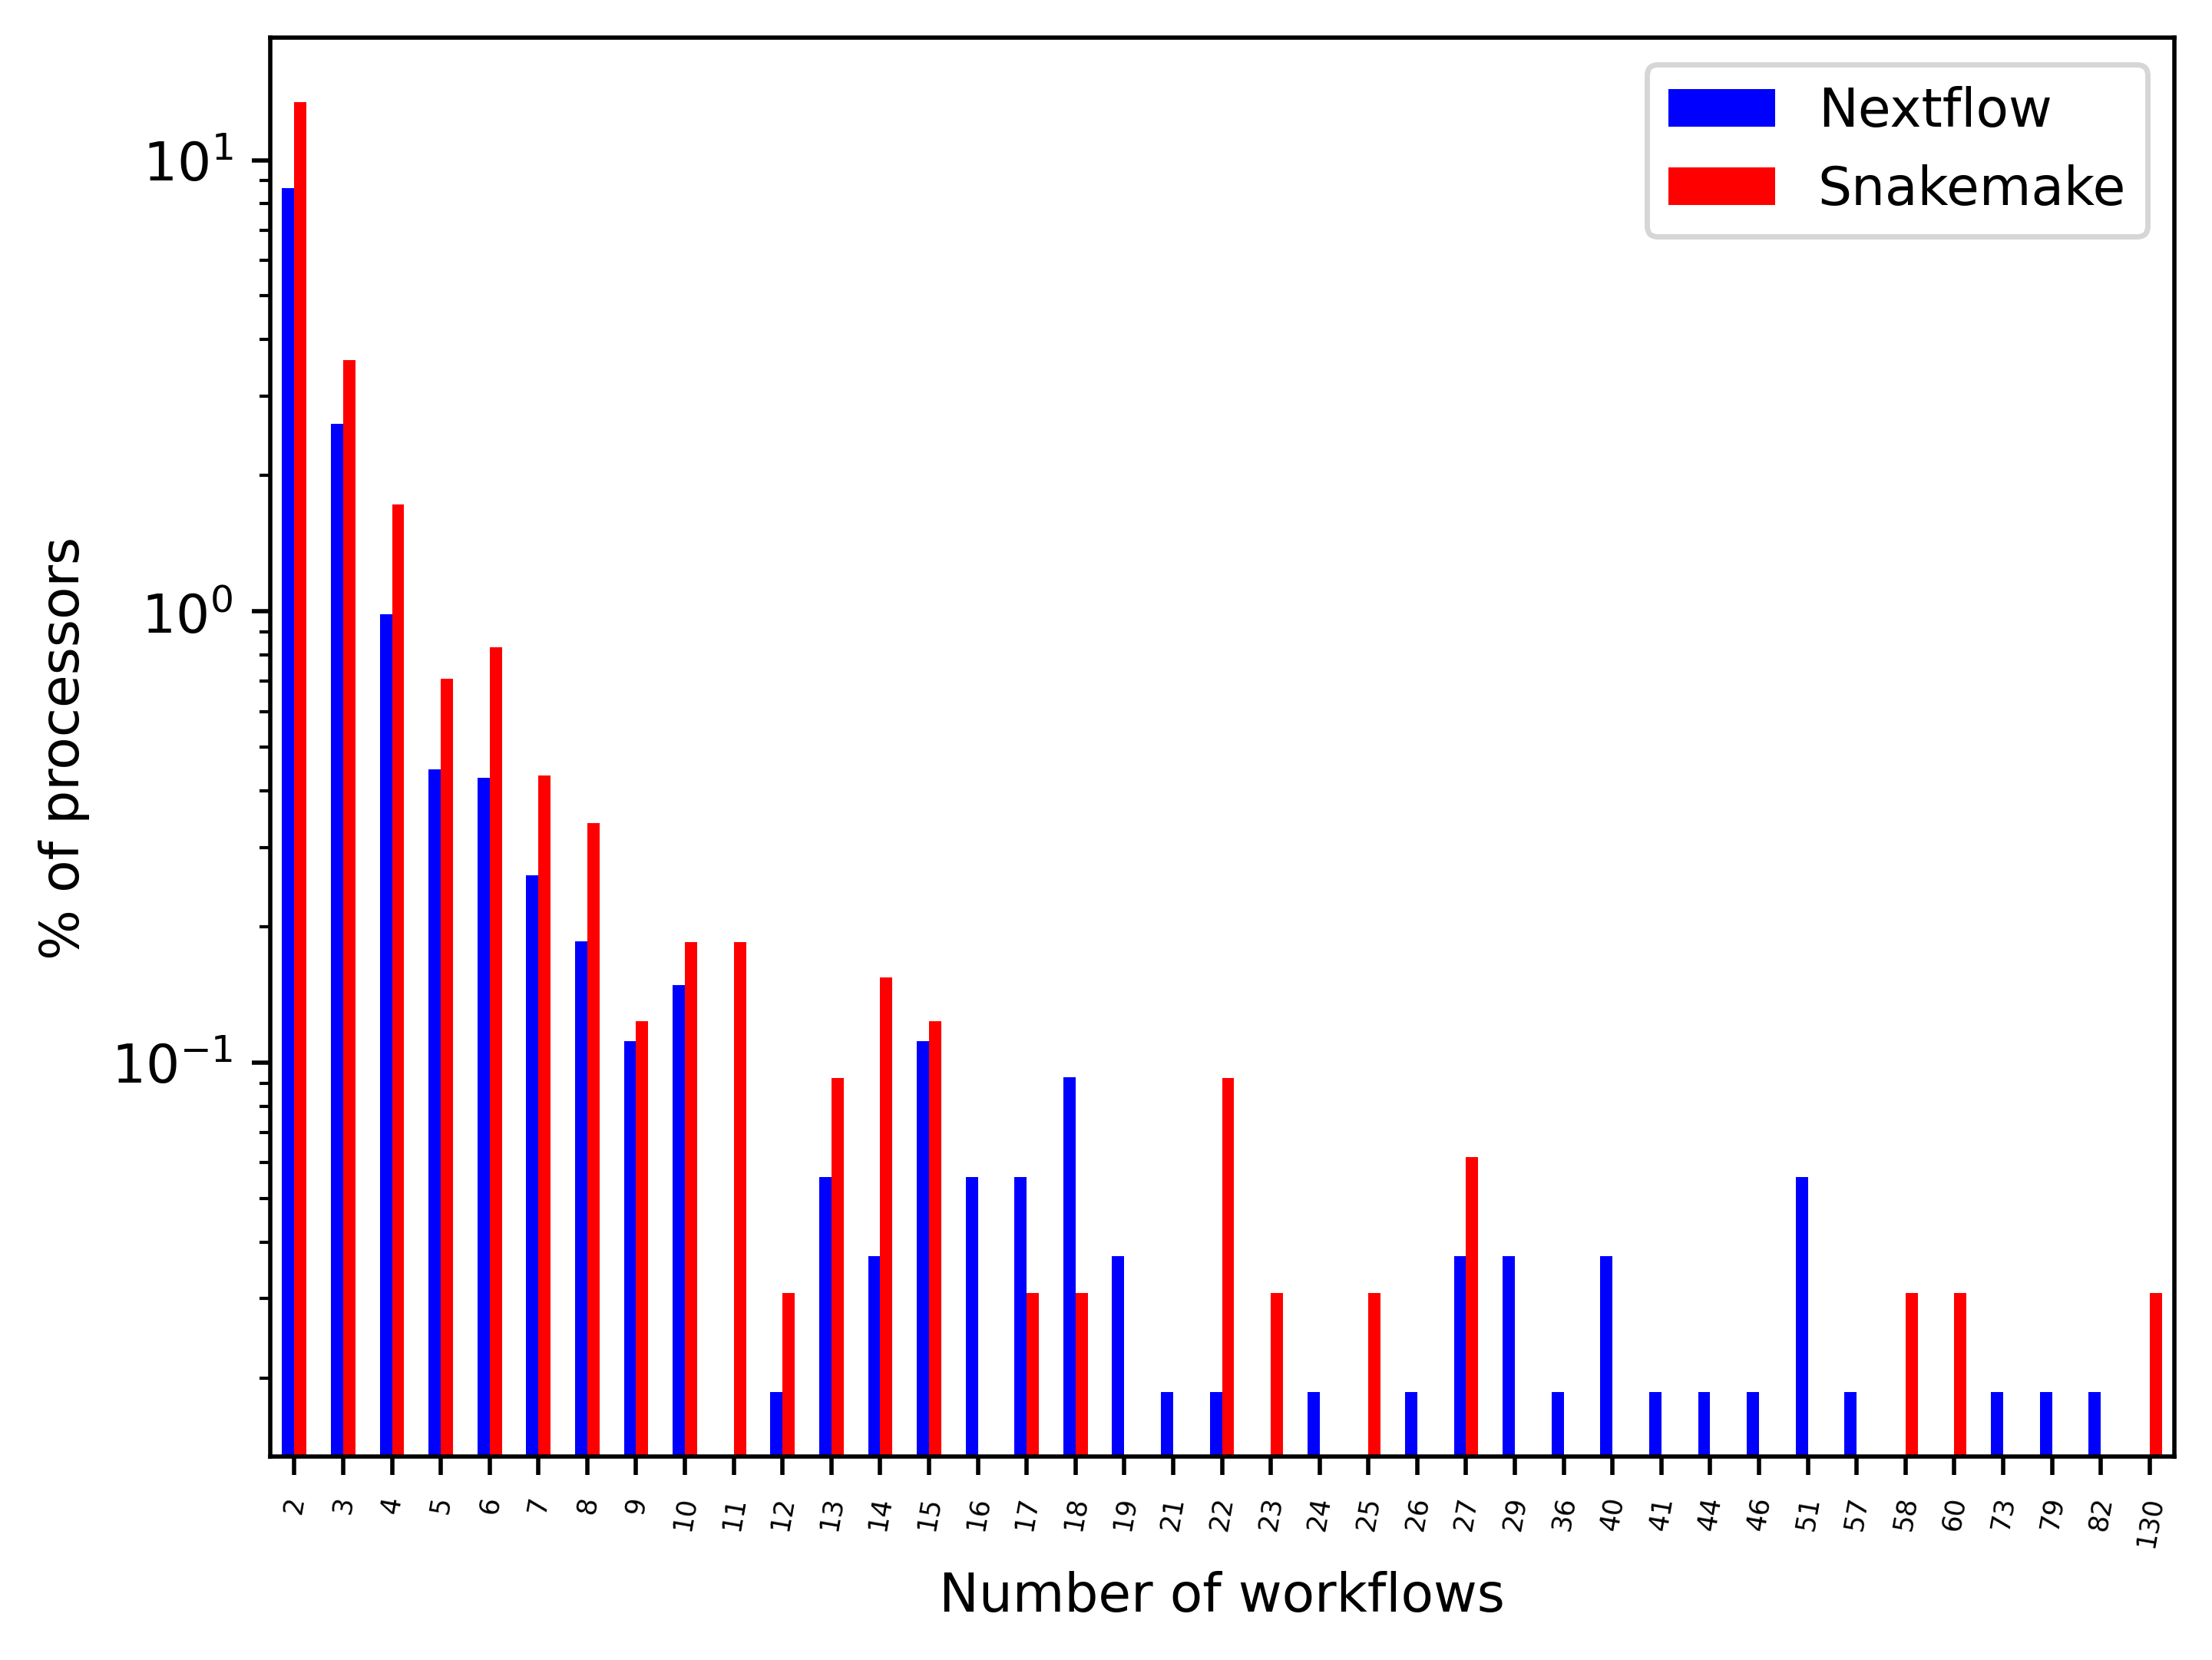

In [16]:
fig_nf_wf = disp_fig_props_wf(df_tot,'nextflow and snakemake')

### Nf-core and non Nf-core processors

In this section, we will compare processor reuse amongst nf-core processors and non nf-core processors. We will look at their reuse in non nf-core workflows (in order to have comparable results, as non nf-core processors are not in nf-core worflows).

In [24]:
def make_df_tot_nfc(df_a,df_b,metric):
    
    df_a["prop_proc_nfc"]=df_a["prop_proc"]
    df_b["prop_proc_non_nfc"]=df_b["prop_proc"]
    df_tot = pd.merge(df_a[[metric,"prop_proc_nfc"]], df_b[[metric,"prop_proc_non_nfc"]],on=metric,how="outer") 
    
    df_tot = df_tot.fillna(0)
    df_tot=df_tot.sort_values(by=[metric], ascending=True)
    return df_tot

In [25]:
def disp_fig_props_wf_nfc(df):
    df_tot = df[df["nb_wf"]>1]    
    df_tot['nb_wf'] = df_tot["nb_wf"].astype(int)
    df_tot = df_tot.sort_values(by="nb_wf")
    fig = df_tot.plot(x="nb_wf",y=["prop_proc_nfc","prop_proc_non_nfc"], kind="bar", color = ['blue',"red"], label = ["nf-core", "non nf-core"])
    fig.set_xticklabels(fig.get_xticklabels(), rotation=80, size=5)
    fig.set_xlabel("Number of workflows")
    fig.set_ylabel('% of processors')
    fig.legend(loc='best')
    fig.set_yscale('log')
    plt.show()
    plt.draw()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    fig.figure.savefig("../figures/hist_reuse_wf_nfc.pdf",bbox_inches = 'tight')

    return fig

In [26]:
df_tot_nfc = make_df_tot_nfc(df_nf_lev_nfc_wf,df_nf_lev_non_nfc_wf,"nb_wf")

/tmp/ipykernel_40397/464505252.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot['nb_wf'] = df_tot["nb_wf"].astype(int)


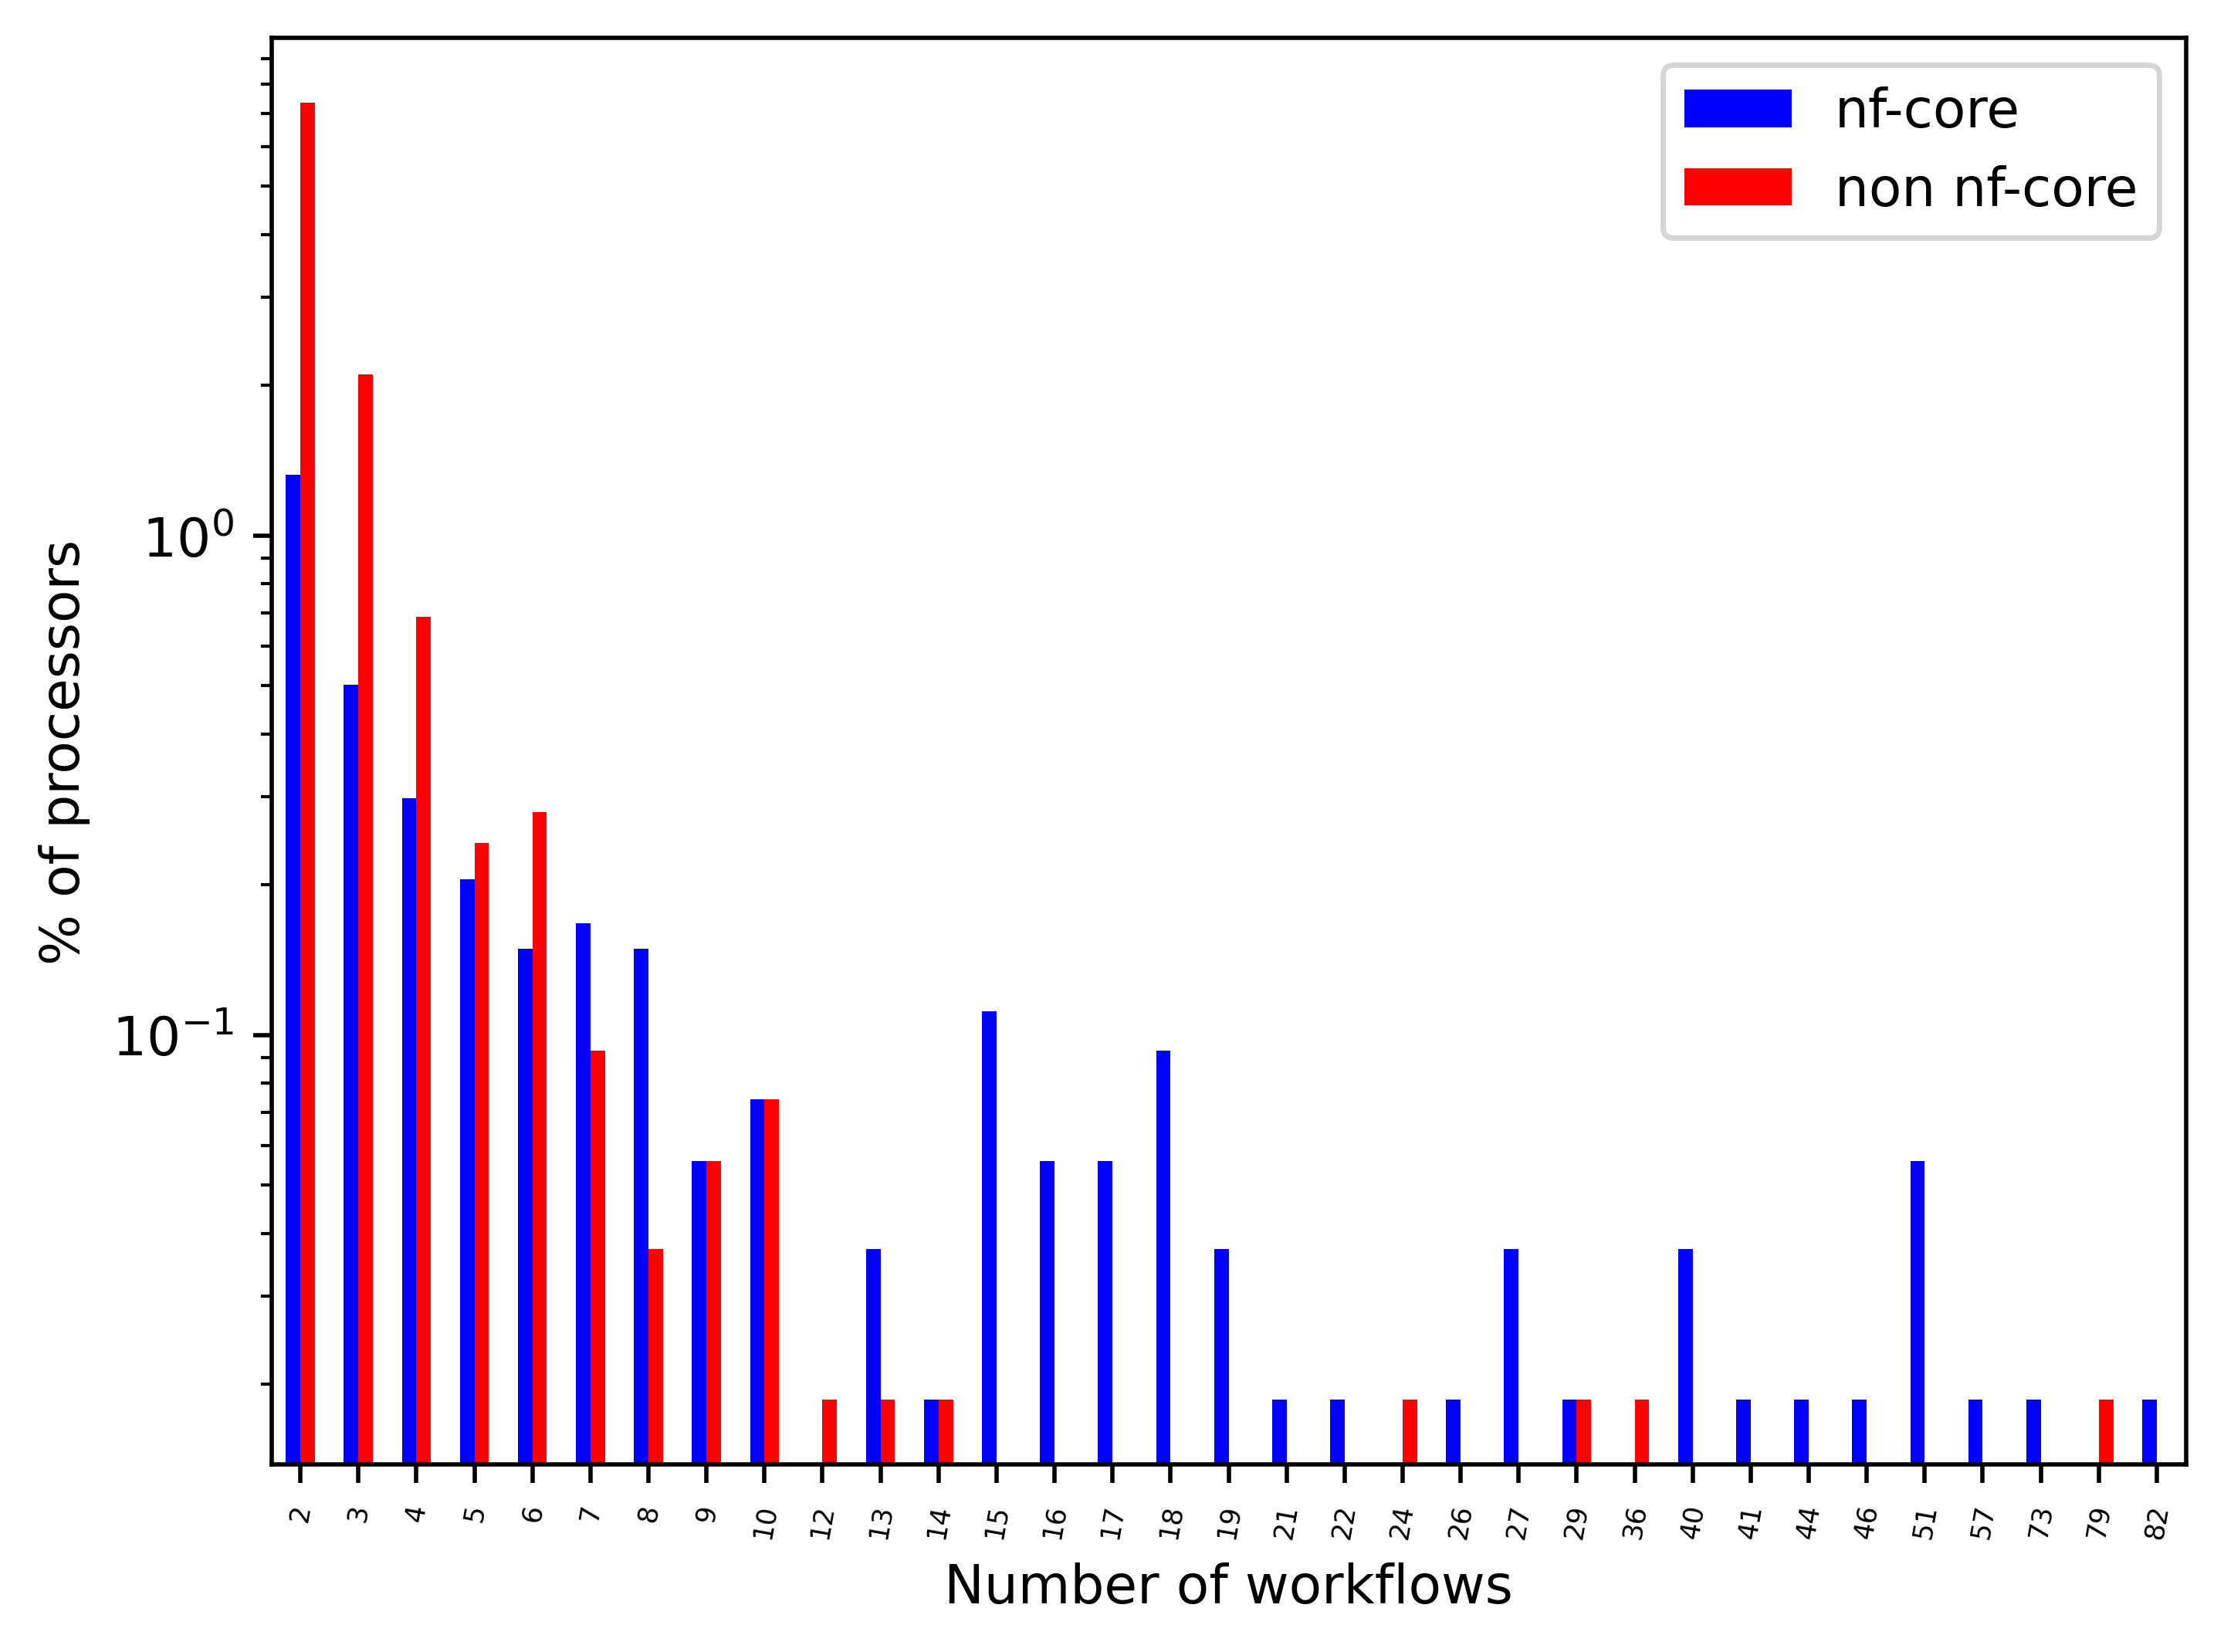

<Figure size 3200x2400 with 0 Axes>

In [27]:
fig_nfc = disp_fig_props_wf_nfc(df_tot_nfc)